In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxTime
from pycox.models.cox_time import MLPVanillaCoxTime
from pycox.evaluation import EvalSurv

In [2]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [3]:
# Dataset

path = "E:/Research/Ovarian Cancer/Articles/Orginal/"
data = pd.read_excel(path+"data_ready2.xlsx")

data.Age = data.Age.apply(lambda x: int(x) if not pd.isna(x) else x)

df_train = data
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [4]:
df_train.head()

,Age,Grading,Histology,Type,Status,MonthSurvive,YearSurvive
1,57,1,7,5,1,1,1
2,33,1,11,5,1,1,1
3,33,1,11,5,1,1,1
4,64,1,7,5,1,1,1
5,52,2,3,5,1,1,1


In [5]:
# Feature transformers

cols_standardize = ['Age']
cols_onehotencoded = ['Grading', 'Histology', 'Type']

standardize = [([col], StandardScaler()) for col in cols_standardize]
onehot_encoded = [([col], OneHotEncoder(handle_unknown='ignore')) for col in cols_onehotencoded]

#encoded = [([col], LabelEncoder()) for col in cols_labelencoded]
#leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + onehot_encoded)

In [6]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [7]:
labtrans = CoxTime.label_transform()
get_target = lambda df: (df['MonthSurvive'].values, df['Status'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))
durations_test, events_test = get_target(df_test)
val = tt.tuplefy(x_val, y_val)

In [8]:
val.shapes()

((428, 25), ((428,), (428,)))

In [ ]:
val.repeat(2).cat().shapes()

In [ ]:
# Neural Net

in_features = x_train.shape[1]
num_nodes = [32, 32]
batch_norm = True
dropout = 0.1
net = MLPVanillaCoxTime(in_features, num_nodes, batch_norm, dropout)

In [ ]:
net

In [ ]:
from torchview import draw_graph
#import graphviz

# when running on VSCode run the below command
# svg format on vscode does not give desired result
#graphviz.set_jupyter_format('png')

In [ ]:
model_graph = draw_graph(MLPVanillaCoxTime(25,1), input_size=(256, 25))
model_graph.visual_graph.node_attr["fontname"] = "Helvetica"
model_graph.resize_graph(scale=2)
img = model_graph.visual_graph

In [ ]:
img.render(format="png")
img

In [87]:
# Training the model

model = CoxTime(net, tt.optim.Adam, labtrans=labtrans)

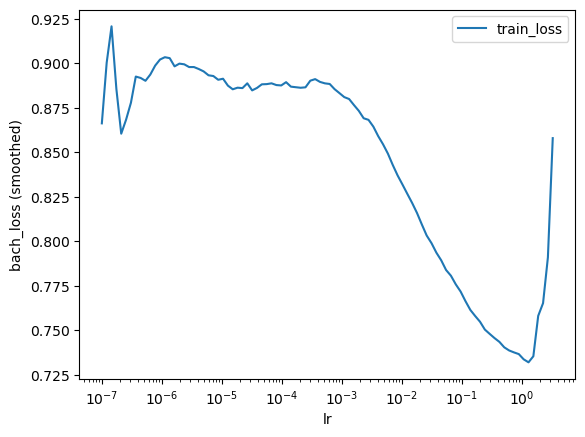

In [88]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=2)
_ = lrfinder.plot()

In [89]:
lrfinder.get_best_lr()

0.12915496650148922

In [90]:
model.optimizer.set_lr(0.01)

In [91]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [92]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val.repeat(10).cat())

0:	[0s / 0s],		train_loss: 0.7698,	val_loss: 0.6750
1:	[0s / 0s],		train_loss: 0.6286,	val_loss: 0.6361
2:	[0s / 0s],		train_loss: 0.6188,	val_loss: 0.6243
3:	[0s / 0s],		train_loss: 0.6180,	val_loss: 0.6110
4:	[0s / 0s],		train_loss: 0.5979,	val_loss: 0.6050
5:	[0s / 0s],		train_loss: 0.5819,	val_loss: 0.6023
6:	[0s / 0s],		train_loss: 0.5816,	val_loss: 0.6044
7:	[0s / 1s],		train_loss: 0.5728,	val_loss: 0.6042
8:	[0s / 1s],		train_loss: 0.5917,	val_loss: 0.6043
9:	[0s / 1s],		train_loss: 0.5797,	val_loss: 0.6111
10:	[0s / 1s],		train_loss: 0.5807,	val_loss: 0.6122
11:	[0s / 1s],		train_loss: 0.5805,	val_loss: 0.6180
12:	[0s / 1s],		train_loss: 0.5894,	val_loss: 0.6129
13:	[0s / 1s],		train_loss: 0.5585,	val_loss: 0.6028
14:	[0s / 1s],		train_loss: 0.5479,	val_loss: 0.6073
15:	[0s / 1s],		train_loss: 0.5852,	val_loss: 0.6114
CPU times: total: 6.98 s
Wall time: 1.84 s


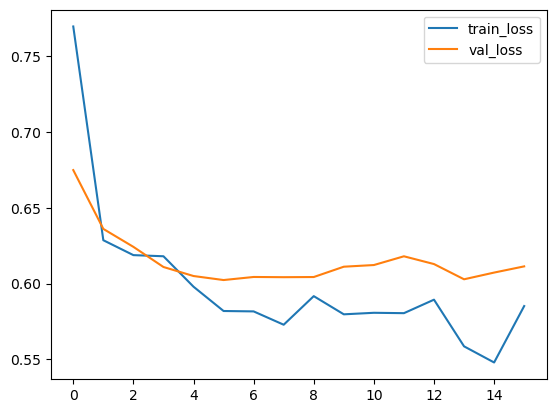

In [93]:
_ = log.plot()

In [94]:
model.partial_log_likelihood(*val).mean()

-5.450955867767334

In [95]:
########### Prediction

_ = model.compute_baseline_hazards()

In [96]:
surv = model.predict_surv_df(x_test)

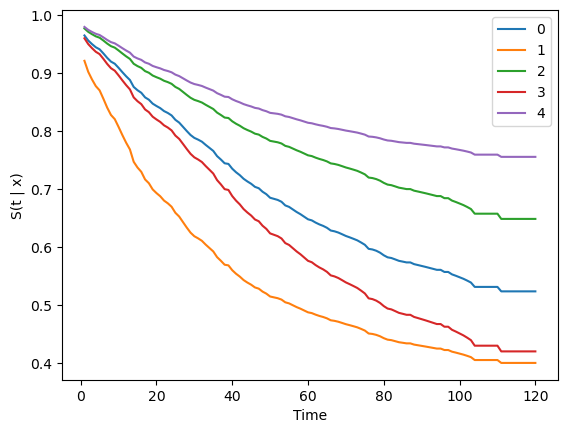

In [97]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [98]:
########## Evaluation

ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [99]:
ev.concordance_td()

0.6693203796158863

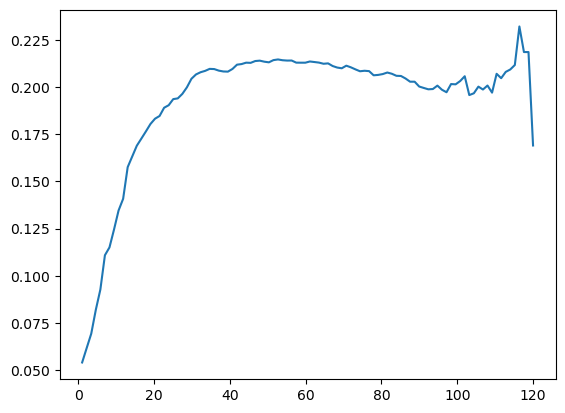

In [100]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [101]:
ev.integrated_brier_score(time_grid)

0.19405712149692636

In [102]:
ev.integrated_nbll(time_grid)

0.5680383129278576